### **1 - Importações**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
%pip install miceforest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from miceforest import ImputationKernel
from sklearn.preprocessing import LabelEncoder
import sklearn.model_selection as ms
import sklearn.linear_model as lm


df = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

SyntaxError: invalid syntax (740372578.py, line 13)

### **2 - Processamento e Análise dos dados**

In [123]:
columns_to_drop = ['listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 
                   'experiences_offered', 'neighborhood_overview', 'amenities', 'last_scraped']
df = df.drop(columns=columns_to_drop)


In [124]:
replacement_dict = {'f': 0, 'v': 1}

# substituição
df['host_is_superhost'] = df['host_is_superhost'].map(replacement_dict)
df['instant_bookable'] = df['instant_bookable'].map(replacement_dict)

In [125]:
replacement_dict = {'f': 0, 'v': 1}

# substituição
teste['host_is_superhost'] = teste['host_is_superhost'].map(replacement_dict)
teste['instant_bookable'] = teste['instant_bookable'].map(replacement_dict)

In [126]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# One-Hot Encoding na coluna 'property_type'
property_types = df[['property_type']].values
encoded_property_types = encoder.fit_transform(property_types)
property_df = pd.DataFrame(encoded_property_types, columns=encoder.get_feature_names_out(['property_type']))

# One-Hot Encoding na coluna 'room_type'
room_type = df[['room_type']].values
encoded_room_types = encoder.fit_transform(room_type)
room_df = pd.DataFrame(encoded_room_types, columns=encoder.get_feature_names_out(['room_type']))


# Atualiza o dataset
df = pd.concat([df, property_df, room_df], axis=1).drop(['property_type', 'room_type'], axis=1)


In [127]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# One-Hot Encoding na coluna 'property_type'
property_types_teste = teste[['property_type']].values
encoded_property_types_teste = encoder.fit_transform(property_types_teste)
property_df_teste = pd.DataFrame(encoded_property_types_teste, columns=encoder.get_feature_names_out(['property_type']))

# One-Hot Encoding na coluna 'room_type'
room_type_teste = teste[['room_type']].values
encoded_room_types_teste = encoder.fit_transform(room_type_teste)
room_df_teste = pd.DataFrame(encoded_room_types_teste, columns=encoder.get_feature_names_out(['room_type']))


# Atualiza o dataset
teste = pd.concat([teste, property_df_teste, room_df_teste], axis=1).drop(['property_type', 'room_type'], axis=1)

In [128]:
cancellation_policy_map = {
    'strict_14_with_grace_period': 1,
    'super_strict_60': 1,
    'super_strict_30': 1,
    'strict': 1,
    'moderate': 2,
    'flexible': 3
}

# Mapeamento manual na coluna 'cancellation_policy'
df['cancellation_policy_encoded'] = df['cancellation_policy'].map(cancellation_policy_map)

In [129]:
# Mapeamento manual na coluna 'cancellation_policy'
teste['cancellation_policy_encoded'] = teste['cancellation_policy'].map(cancellation_policy_map)

In [130]:
for column in teste.columns:
    if column not in df.columns:
        teste = teste.drop(columns=[column])

In [131]:
for column in df.columns:
    if column != 'price' and column not in teste.columns:
        df = df.drop(columns=[column])

In [132]:
df.head()

,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,947924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2747040,10.0,10.0,30.0,30.0,10.0,30.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
2,13734316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
3,30979175,2.0,4.0,15.0,15.0,2.4,15.0,20.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
4,3742926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0


In [133]:
# Aplicando Multiple Imputation após transformar o dataset todo com dados numéricos
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = df[column].astype(str)  
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

mice_kernel = ImputationKernel(
data = df,
save_all_iterations_data= True,
random_state = 500
)

In [134]:
# Aplicando Multiple Imputation após transformar o dataset todo com dados numéricos
label_encoders = {}
for column in teste.columns:
    le = LabelEncoder()
    teste[column] = teste[column].astype(str)  
    teste[column] = le.fit_transform(teste[column])
    label_encoders[column] = le

mice_kernel = ImputationKernel(
data = teste,
save_all_iterations_data= True,
random_state = 500
)

In [135]:
total_missing = df.isna().sum().sum()
print(f"Total de valores faltantes: {total_missing}")

Total de valores faltantes: 0


In [136]:
df.head()

,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,63379,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,0,0,0,1,0,0
1,32122,1,1,129,131,10,635,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,9580,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,0,1,0,0,0,2
3,38267,30,66,62,64,136,298,22,1,0,...,0,0,0,0,0,1,0,0,0,1
4,47480,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,0,0,0,1,0,2


In [137]:
teste.head()

,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,17587,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
1,26489,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
2,48974,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
3,49230,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,0,0,1,0,0
4,49603,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0


### **3 - Regressão Linear**

In [138]:
#valor médio da variável price
mean_value_target = df['price'].mean()
mean_value_target

2974.849014863346

In [139]:
sse = pd.Series(mean_value_target - df['price'])**2
squared_errors = np.sum(sse)
print('SSE: %01.f' % squared_errors)

SSE: 1558537717743


<Axes: xlabel='price', ylabel='Count'>

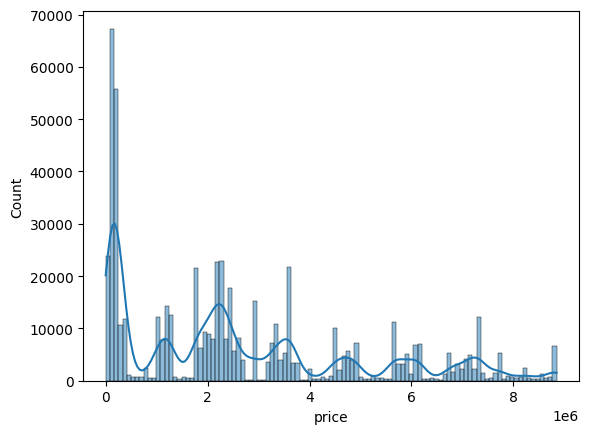

In [140]:
import seaborn as sns

sns.histplot(data = sse, kde = True)

In [141]:
col_24 = df.columns[24]

# Criar uma lista de colunas sem a coluna 24
new_order = [col for col in df.columns if col != col_24]

# Adicionar a coluna 24 ao final da lista
new_order.append(col_24)

# Reordenar o DataFrame
df = df[new_order]

X = df.drop(columns=['price'])
y = df['price']

df.head()

,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded,price
0,63379,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,0,0,1,0,0,2561
1,32122,1,1,129,131,10,635,0,1,0,...,0,0,0,0,1,0,0,0,1,502
2,9580,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,1,0,0,0,2,4528
3,38267,30,66,62,64,136,298,22,1,0,...,0,0,0,0,1,0,0,0,1,4121
4,47480,95,109,284,286,422,1335,108,120,23,...,0,0,0,0,0,0,1,0,2,1348


In [142]:


teste.head()

,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,17587,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
1,26489,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
2,48974,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0
3,49230,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,0,0,1,0,0
4,49603,86,95,255,257,297,761,107,120,23,...,0,0,0,0,0,1,0,0,0,0


In [143]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size= 1/8, random_state= 0)

In [144]:
regressor = lm.LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [145]:
y_pred = regressor.predict(X_test)

y_pred = np.array(y_pred)
y_test = np.array(y_test)

np.set_printoptions(precision=2)
y_pred = y_pred.reshape(len(y_pred), 1)
y_test = y_test.reshape(len(y_test), 1)
result = np.concatenate((y_pred, y_test), axis=1)

print(result)

[[2592.85 1476.  ]
 [3179.91  503.  ]
 [2961.9  3987.  ]
 ...
 [2931.25 4019.  ]
 [2951.9  4824.  ]
 [3056.17 1635.  ]]


In [146]:
X_reverse = X_test.reset_index(drop=True)

y_compare = pd.DataFrame(result)
y_compare = y_compare.rename(index = str, columns={0: 'y_pred', 1: 'y_test'})
y_compare = y_compare.reset_index(drop=True)

resultado_final = pd.concat([y_compare, X_reverse], axis = 1)

resultado_final

,y_pred,y_test,id,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,...,property_type_Townhouse,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_encoded
0,2592.849576,1476.0,32018,1,1,23,23,10,149,0,...,0,0,0,0,0,1,0,0,0,1
1,3179.908274,503.0,12548,0,46,225,227,136,1070,1,...,0,0,0,0,0,0,0,1,0,1
2,2961.903901,3987.0,59221,30,31,211,213,132,1003,15,...,0,0,0,0,0,1,0,0,0,0
3,2845.743361,2614.0,40879,30,31,38,38,132,215,0,...,0,0,0,0,0,0,0,1,0,2
4,3105.255997,2059.0,59708,30,31,38,38,132,215,0,...,0,0,0,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73507,3458.901022,5683.0,6819,95,109,284,286,422,1335,108,...,0,0,0,0,0,0,0,1,0,1
73508,3062.510699,2576.0,60453,46,48,160,162,252,773,0,...,0,0,0,0,0,1,0,0,0,0
73509,2931.248044,4019.0,44087,30,46,258,260,132,1239,0,...,0,0,0,0,0,0,0,1,0,0
73510,2951.899973,4824.0,20377,0,0,233,235,0,1093,22,...,0,0,0,0,0,0,0,1,0,2


In [147]:
y_pred_teste = regressor.predict(teste)

# Criação do DataFrame de submissão
submission = pd.DataFrame({'ID': teste['id'], 'PRICE': y_pred_teste})

# Salvando o arquivo de submissão
submission.to_csv('submission.csv', index=False)
